# Model of auxotrophic communities with mutations in update and production rates of amino acids

Note: equation numbers refer to main text of van Vliet et al Plos Comp Bio 2022.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))


## Community class definition
We start with defining a python class that describes community using equation from van Vliet et al Plos Comp Bio 2022.
You do not need to modify anything here

In [2]:
class community:
    """Class for a community of auxotrophs, based on model described in van Vliet et al, PLoS Comp Bio 2020"""

    def __init__(self, c_up_T=1, c_up_P=1, c_prod_T=1, c_prod_P=1, c_cost_dT=1, c_cost_dP=1, **kwargs):
        """Initialize the community with a set of parameters
        
            c_up_T: factor that scales uptake rate of trp in dTrp
            c_up_P: factor that scales uptake rate of pro in dPro
            c_prod_T: factor that scales production rate of trp in dPro
            c_prod_P: factor that scales production rate of pro in dTrp
            c_cost_dT: factor that scales growth rate of dTrp mutant
            c_cost_dP: factor that scales growth rate of dPro mutant            
        
        """
        
        self.par_names = ['upPro', 'upTrp', 'DiffP', 'DiffT', 'lPro', 'lTrp', 'ic', 'mu0', 'rho', 'rho2d', 'cell_l', 'cell_w', 'beta']
          
        # parameters for the model, see S1 Table in the paper
        self.upPro = 2.04 
        self.upTrp = 24.05 
        self.DiffP = 879 
        self.DiffT = 659 
        self.lPro = 1.59e-5
        self.lTrp = 6.04e-7 
        self.ic = 20 
        self.mu0 = 1.29/3600 
        self.rho = 0.65 
        self.rho2d = 0.22 
        self.cell_l = 5.2 
        self.cell_w = 0.68 
        self.beta = 0.88
        
        #set scaling factors
        self.c_up_T = c_up_T
        self.c_up_P = c_up_P
        self.c_prod_T = c_prod_T
        self.c_prod_P = c_prod_P
        self.c_cost_dT = c_cost_dT
        self.c_cost_dP = c_cost_dP
        
        #set other parameters
        self.set_parameters(kwargs)
        
        #calc community properties
        self.calc_interaction_parameters()
        self.calc_eq_prop() 
    
    
        
        return None
            
    ## model initialization functions
    def set_parameters(self, dict):
        '''set model parameters from dictionary
        input:
            dict: dictionary with model parameters
        '''
        #assign custom variables
        for key, value in dict.items():
            if key in self.par_names:
                setattr(self, key, value)    
            else:
                Warning(("%s is an invalid parameter name, ignoring this" % key))  
        return None  
    
    
    def calc_interaction_parameters(self):
        #calculate interaction parameters of the community
        #DP depends on Pro, producer of Pro is DT, non-producer is DP
        self.muP = self.calc_mu_max(up_auxo = self.upPro * self.c_up_P, 
                                    leak_auxo = self.lPro, 
                                    up_prod = self.upPro, 
                                    leak_prod = self.lPro * self.c_prod_P,
                                    mu_auxo=self.mu0 * self.c_cost_dP
                                    )
        
        self.rangeP = self.calc_int_range(up_auxo = self.upPro * self.c_up_P, 
                                          leak_auxo = self.lPro, 
                                          up_prod = self.upPro, 
                                          leak_prod = self.lPro * self.c_prod_P,
                                          D = self.DiffP,
                                          mu_auxo=self.mu0 * self.c_cost_dP
                                          )
        
        self.nbP = self.calc_int_nb(self.rangeP)
        
        #DT depends on Trp, producer of Trp is DP, non-producer is DT
        self.muT = self.calc_mu_max(up_auxo = self.upTrp * self.c_up_T, 
                                    leak_auxo = self.lTrp, 
                                    up_prod = self.upTrp, 
                                    leak_prod = self.lTrp * self.c_prod_T,
                                    mu_auxo=self.mu0 * self.c_cost_dT)
        
        self.rangeT = self.calc_int_range(up_auxo = self.upTrp * self.c_up_T, 
                                          leak_auxo = self.lTrp, 
                                          up_prod = self.upTrp, 
                                          leak_prod = self.lTrp * self.c_prod_T,
                                          D = self.DiffT,
                                          mu_auxo=self.mu0 * self.c_cost_dT)        
        
        self.nbT = self.calc_int_nb(self.rangeT)
        
        return None
    
    
    def calc_mu_max(self, up_auxo=1, up_prod=1, leak_auxo=1, leak_prod=1, mu_auxo=None):
        """Calculate the maximum growth rate of the cell

        Following equation 10 & 11 in S1 Text
        
        Growth rate is returned in units of h^-1 
        
        """
        
        mu_auxo = self.mu0 if mu_auxo is None else mu_auxo

        theta = ((leak_prod * self.ic)/(2 * mu_auxo)) * ((up_auxo + leak_auxo)/(up_prod + leak_prod))
        mu_max = mu_auxo * theta * (np.sqrt(1 + 2 / theta) - 1)        
        return 3600*mu_max
    
    def calc_int_range(self, up_auxo=1, up_prod=1, leak_auxo=1, leak_prod=1, D=1, mu_auxo=None):
        '''calculate the interaction range of the cell
        
        Following equation 17 in S1 Text
        
        Range is returned in units of um
        
        '''
        
        mu_auxo = self.mu0 if mu_auxo is None else mu_auxo
        
        theta = ((leak_prod * self.ic)/(2 * mu_auxo)) * ((up_auxo + leak_auxo)/(up_prod + leak_prod))
        delta = theta * (2 * np.sqrt(up_prod + leak_prod)) / (np.sqrt(up_auxo + leak_auxo) + np.sqrt(up_prod + leak_prod))
        r0 = self.calc_r0(up_auxo, leak_auxo, D, self.rho)
        range = self.beta * r0 *  np.log(4 + \
                delta * (1 + np.sqrt(1 + 4 / delta)))
        return range
    
    def calc_int_nb(self, range):
        '''convert interaction range to number of neighbors
        
        Following equation 21 in S1 Text
        
        '''
        range = (2 * range * (self.cell_l - self.cell_w) + np.pi * (range + self.cell_w/2)**2 - np.pi * (self.cell_w/2)**2) * self.rho2d
        return np.round(range)
        
    def calc_eq_prop(self):
        '''calculate equilibrium properties of the community
        
        Equilibrium frequency (eq) is calculated following equation 16 in S2 Text
        Equilibrium frequency in well mixed system (eq_wm) is calculated following equation 20 in S2 Text
        Clustering of DT (clusteringT) and DP (clusteringP) is calculated following equation 17 and 18 in S2 Text
        Community growth rate relative to growth rate in well mixed system (rel_growth) is calculated following equation 29 & 30 in S2 Text
        
        '''
        self.eq = (self.muT * (self.nbT - 2)/self.nbT + (self.muT/self.nbT - self.muP/self.nbP)) / (self.muT * (self.nbT - 2)/self.nbT + self.muP * (self.nbP - 2)/self.nbP)
        self.eq_wm = self.muT / (self.muT + self.muP)      
        
        self.clusteringT = (self.nbT - 2) / (self.nbT - 1)
        self.clusteringP = (self.nbP - 2) / (self.nbP - 1)

        pT = self.eq
        pP = 1-self.eq
        pPT = self.clusteringT * pP 
        pTP = self.clusteringP * pT
        growth = pT * pPT * self.muT + pP * pTP * self.muP
        growth_wm = self.eq_wm * (1-self.eq_wm) * self.muT + (1-self.eq_wm) * self.eq_wm * self.muP
                
        self.rel_growth_wt = growth / (3600 * self.mu0)        
        self.rel_growth_wm = growth / growth_wm
        
        return None
    
    def calc_growth_profiles(self, x_vec=np.linspace(0,10,100)):
        ''' Calculates growth profiles of the community, assuming the two types occupy different sides of the community.
        
        DT on left, x<0; DP on right, x>0
        '''
        
        #Calculate growth profile of DT
        lTrp_prod = self.lTrp * self.c_prod_T # production rate of Trp in DP
        upTrp_auxo = self.upTrp * self.c_up_T # uptake rate of Trp in DT
        ext_Trp = self.ext_profile_auxo(x_vec, 
                                        up_prod=self.upTrp, 
                                        leak_prod=lTrp_prod, 
                                        r0_prod=self.calc_r0(self.upTrp, lTrp_prod, self.DiffT, self.rho), 
                                        r0_auxo=self.calc_r0(self.upTrp, self.lTrp, self.DiffT, self.rho))
        
        int_Trp = self.int_of_ext(ext_Trp, up=upTrp_auxo, leak=self.lTrp, mu0=self.mu0 * self.c_cost_dT)
        self.mu_profile_T = self.mu_of_int(int_Trp, mu0=self.mu0 * self.c_cost_dT) 
        self.x_T = -x_vec
        
        #Calculate growth profile of DP
        lPro_prod = self.lPro * self.c_prod_P # production rate of Pro in DT
        upPro_auxo = self.upPro * self.c_up_P # uptake rate of Pro in DP
        ext_Pro = self.ext_profile_auxo(x_vec, 
                                        up_prod=self.upPro, 
                                        leak_prod=lPro_prod, 
                                        r0_prod=self.calc_r0(self.upPro, self.lPro, self.DiffP, self.rho), 
                                        r0_auxo=self.calc_r0(upPro_auxo, self.lPro, self.DiffP, self.rho))
        
        int_Pro = self.int_of_ext(ext_Pro, up=upPro_auxo, leak=self.lPro, mu0=self.mu0 * self.c_cost_dP)
        
        self.mu_profile_P = self.mu_of_int(int_Pro, mu0=self.mu0 * self.c_cost_dP)
        self.x_P = x_vec

        return None
    
    def report_properties(self):
        '''report properties of the community'''
        print(f"Frequency dT = {self.eq:.2f}")
        print(f"Clustering dT = {self.clusteringT:.2f}, Clustering dP = {self.clusteringP:.2f}")
        print(f"Growth relative to WT = {self.rel_growth_wt:.2f}")        
        print(f"Growth defect spatial community = {self.rel_growth_wm:.2f}")        
        print(f"mu_max dP = {self.muP:.2f}, mu_max dT = {self.muT:.2f}")
        print(f"range dP = {self.rangeP:.2f}um, range dT = {self.rangeT:.2f}um")
        
        return None
    
    def ext_profile_prod(self, x_vec, leak_prod=1, up_prod=1, r0_prod=1, r0_auxo=1):
        ''' Calculate external concentration profile in area of producer
        
        Following equation 14 in S1 Text
        
        '''
        ext = self.ic * leak_prod * (r0_auxo - r0_prod * np.exp(x_vec/r0_prod) + r0_prod) / \
                ((leak_prod + up_prod) * (r0_auxo + r0_prod))
        return ext
        
    def ext_profile_auxo(self, x_vec, leak_prod=1, up_prod=1, r0_prod=1, r0_auxo=1):
        ''' Calculate external concentration profile in area of auxotroph
        
        Following equation 14 in S1 Text
        
        '''        
        ext = self.ic * leak_prod * r0_auxo * np.exp(-x_vec/r0_auxo) / \
                ((leak_prod + up_prod) * (r0_auxo + r0_prod))
        return ext        
        
    def calc_r0(self, up, leak, D, rho):
        ''' Calculate length scale of diffusion, r0
        
        Following equation 12 in S1 Text
        
        '''
        
        effective_D = D * (1 - rho)**2 / (rho * (1 + rho / 2))
        return np.sqrt( (effective_D) / (up + leak))
    
    def int_of_ext(self, ext, up=1, leak=1, mu0=1):
        ''' Convert external concentration to internal concentration
        
        Following equation 7 in S1 Text
        
        '''
        intC = ((up + leak) * ext - leak + np.sqrt(((up + leak)*ext + leak)**2 + 4 * (up + leak) * mu0 * ext) ) / (2 * (mu0 + leak))
        return intC
    
    def mu_of_int(self, intC, mu0=1):
        ''' Calculate growth rate from internal concentration
        
        Following Monod equation
        
        Output is in units of h^-1
        
        '''
        return 3600 * (mu0 * intC) / (1 + intC)    

In [3]:
def plot_growth_profile(community):
    ''' Plot growth profiles of the community
    
    Parameters:
    
    community: community object
    
    Returns:
    
    fig: figure object
    
    '''
    
    
    #set colors
    yellow = np.array([246,219,147])/255
    blue = np.array([42,86,152])/255
    
    #calculate growth profiles
    x_vec = np.linspace(0,30,1000)
    community.calc_growth_profiles(x_vec)
    
    #normalize to WT growth rate
    muWT = community.mu0 * 3600
    
    #plot growth profiles
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(community.x_T, community.mu_profile_T/muWT, color=yellow, label='dT')
    ax.plot(community.x_P, community.mu_profile_P/muWT, color=blue, label='dP')
    ax.set_xlabel('Position (um)')
    ax.set_ylabel('Growth rate relative to WT')
    ax.set_ylim(0,1)
    
    #add reference lines
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=community.rangeP, color=blue, linestyle=':')
    plt.axvline(x=-community.rangeT, color=yellow, linestyle=':')

    return fig

---

## Check original community

We can now check the properties of the original community to confirm we find the same values as in table S3 of our paper.
There are minor differences as there was a small error in our paper in the conversion of interaction range to number of neighbors.

We also plot the growth rate profiles across the interface. The dotted vertical lines represent the calculated growth range.

Frequency dT = 0.20
Clustering dT = 0.90, Clustering dP = 0.99
Growth relative to WT = 0.12
Growth defect spatial community = 0.92
mu_max dP = 0.77, mu_max dT = 0.22
range dP = 12.17um, range dT = 2.52um


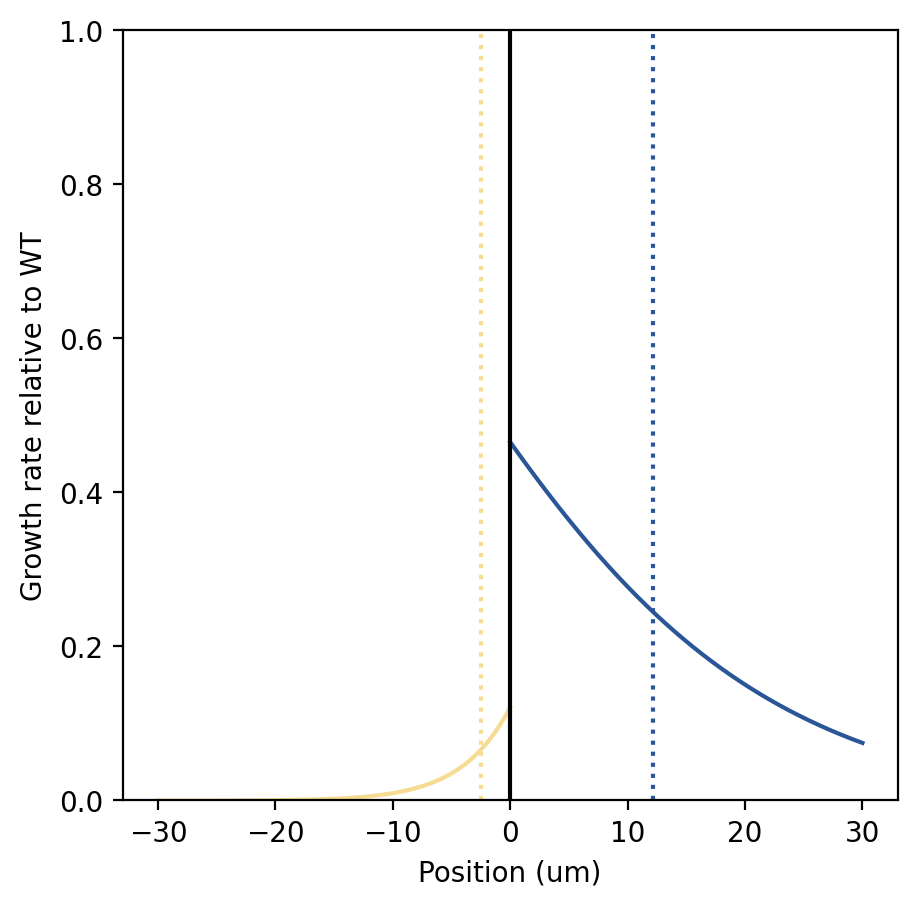

In [4]:
wt_community = community()
wt_community.report_properties()
fig = plot_growth_profile(wt_community)

---

## Load data

In [5]:
df = pd.read_csv('data.csv')
df['rel_range'] = df['dP_patch']/df['dT_patch']
df.head(n=9)

,Condition,Rep,Ratio,Width,dT_patch,dP_patch,rel_range
0,A,1,0.260160,98.019242,9.982812,31.874861,3.192974
1,B,1,0.420748,157.745055,7.487109,6.117064,0.817013
2,C,1,0.590506,-0.064086,7.487109,11.631545,1.553543
3,D,1,0.625429,293.174008,8.314437,4.991406,0.600330
4,E,1,0.189678,805.362453,119.452271,231.705899,1.939736
5,F,1,0.386470,852.126212,125.763148,148.161343,1.178098
6,G,1,0.411337,824.371877,114.111317,162.914291,1.427679
7,H,1,0.404812,873.116202,132.916806,135.954874,1.022857
8,WT,1,0.544112,1083.906711,184.888467,720.857747,3.898879


---

### Fit cost function

In [18]:
def fit_1D(x, y_data, y_model):
    
    #check if y data is numpy array
    if isinstance(y_data, np.ndarray):
        delta = (y_model[np.newaxis,:] - y_data[:,np.newaxis])
        L2_norm = (delta**2).sum(axis=0)
    else:
        delta = y_model[np.newaxis,:] - y_data
        L2_norm = (delta**2)
    
    min_idx = np.argmin(L2_norm)
    
    fitted_x = x[min_idx]
    fitted_y = y_model[min_idx]
    
    fig, axs = plt.subplots(1,1,figsize=(5,3))
    
    axs.plot(x, y_model, label='model')
    axs.plot(x, np.ones_like(x) * y_data.mean(), label='data')
    axs.axvline(x=fitted_x, color='k', linestyle='--')
    
    return (fitted_x, fitted_y)    

def fit_2D(x, y, z1, z2, z1_data, z2_data, log_scale=False):
      
    delta1 = (z1[:, :, np.newaxis] - z1_data[np.newaxis, np.newaxis, :])/z1_data[np.newaxis, np.newaxis, :]
    L2_norm1 = (delta1**2).sum(axis=2)

    delta2 = (z2[:, :, np.newaxis] - z2_data[np.newaxis, np.newaxis, :])/z2_data[np.newaxis, np.newaxis, :]
    L2_norm2 = (delta2**2).sum(axis=2)

    L2_norm_comb = np.log10(L2_norm1 + L2_norm2)


    idx_y, idx_x = np.unravel_index(np.argmin(L2_norm_comb), L2_norm_comb.shape)
    xfit = x[idx_x]
    yfit = y[idx_y]

    fig,axs = plt.subplots(1,3,figsize=(15,5))

    im0 = axs[0].imshow(z1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im0, ax=axs[0])
    axs[0].contour(x, y, z1, levels=[z1_data.mean()], colors='r')
    axs[0].contour(x, y, z2, levels=[z2_data.mean()], colors='m')
    axs[0].axvline(x=xfit, color='k', linestyle='--')
    axs[0].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

    im1 = axs[1].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[1])
    axs[1].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[1].contour(x, y, z2, levels=[z2_data.mean()], colors='r')
    axs[1].axvline(x=xfit, color='k', linestyle='--')
    axs[1].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

    im2 = axs[2].imshow(L2_norm_comb, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    fig.colorbar(im2, ax=axs[2])
    axs[2].axvline(x=xfit, color='k', linestyle='--')
    axs[2].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[2].set_xscale('log')
        axs[2].set_yscale('log')

    return (xfit, yfit)


def fit_3D(x, y, z1, z2, z3, z1_data, z2_data, z3_data):
      
    delta1 = (z1[:, :, np.newaxis] - z1_data[np.newaxis, np.newaxis, :])/z1_data[np.newaxis, np.newaxis, :]
    L2_norm1 = (delta1**2).sum(axis=2)

    delta2 = (z2[:, :, np.newaxis] - z2_data[np.newaxis, np.newaxis, :])/z2_data[np.newaxis, np.newaxis, :]
    L2_norm2 = (delta2**2).sum(axis=2)
    
    delta3 = (z3[:, :, np.newaxis] - z3_data[np.newaxis, np.newaxis, :])/z3_data[np.newaxis, np.newaxis, :]
    L2_norm3 = (delta3**2).sum(axis=2)

    L2_norm_comb = np.log10(L2_norm1 + L2_norm2 + L2_norm3)

    idx_y, idx_x = np.unravel_index(np.argmin(L2_norm_comb), L2_norm_comb.shape)
    xfit = x[idx_x]
    yfit = y[idx_y]

    fig,axs = plt.subplots(1,4,figsize=(20,5))

    im0 = axs[0].imshow(z1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im0, ax=axs[0])
    axs[0].contour(x, y, z1, levels=[z1_data.mean()], colors='r')
    axs[0].contour(x, y, z2, levels=[z2_data.mean()], colors='m')
    axs[0].contour(x, y, z3, levels=[z3_data.mean()], colors='c')
    axs[0].axvline(x=xfit, color='k', linestyle='--')
    axs[0].axhline(y=yfit, color='k', linestyle='--')


    im1 = axs[1].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[1])
    axs[1].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[1].contour(x, y, z2, levels=[z2_data.mean()], colors='r')
    axs[1].contour(x, y, z3, levels=[z3_data.mean()], colors='c')
    axs[1].axvline(x=xfit, color='k', linestyle='--')
    axs[1].axhline(y=yfit, color='k', linestyle='--')
    
    im2 = axs[2].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[2])
    axs[2].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[2].contour(x, y, z2, levels=[z2_data.mean()], colors='c')
    axs[2].contour(x, y, z3, levels=[z3_data.mean()], colors='r')
    axs[2].axvline(x=xfit, color='k', linestyle='--')
    axs[2].axhline(y=yfit, color='k', linestyle='--')

    im3 = axs[3].imshow(L2_norm_comb, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    fig.colorbar(im3, ax=axs[3])
    axs[3].axvline(x=xfit, color='k', linestyle='--')
    axs[3].axhline(y=yfit, color='k', linestyle='--')


    return (xfit, yfit)


---
## Try to fit density based on community A

We fit density based on sector size from WT community, we assume that sector size is limited such that all cells are within interaction range from partner type, in other words the sector size equals 2x the interaction range.

This does not work well, we cannot find a density that matches both types well enough.

rho = 0.53, sector dP = 31.87um, range DP = 18.40, sector dT = 9.98um, range DT = 3.82


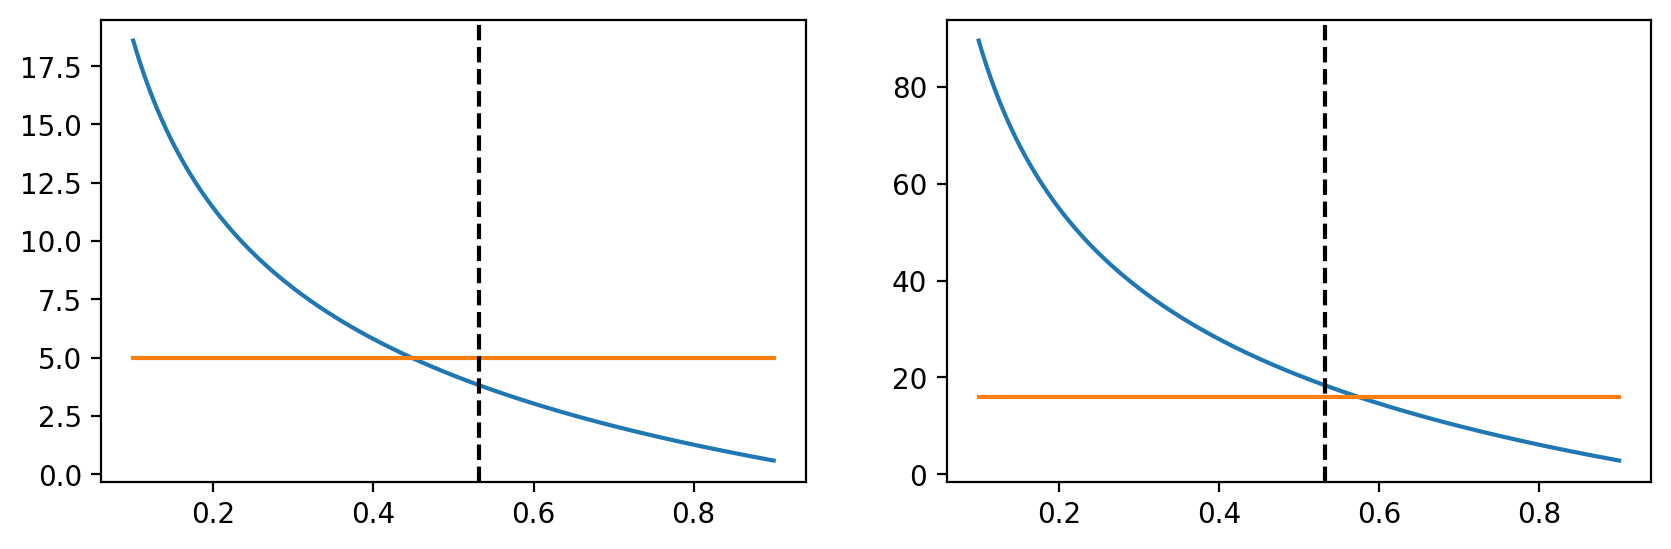

In [9]:
rho_vec = np.linspace(0.1,0.9,801)
community_A = community(rho=rho_vec)

sectorT = df.loc[df['Condition']=='A']['dT_patch'].values 
sectorP = df.loc[df['Condition']=='A']['dP_patch'].values

est_rangeT = sectorT/2
est_rangeP = sectorP/2
deltaT = (community_A.rangeT[np.newaxis,:] - est_rangeT[:,np.newaxis])/est_rangeT[:,np.newaxis]
deltaP = (community_A.rangeP[np.newaxis,:] - est_rangeP[:,np.newaxis])/est_rangeP[:,np.newaxis]
L2_norm = (deltaT**2).sum(axis=0) + (deltaP**2).sum(axis=0)
min_idx = np.argmin(L2_norm)

rho_opt = rho_vec[min_idx]

print(f"rho = {rho_opt:.2f}, sector dP = {sectorP.mean():.2f}um, range DP = {community_A.rangeP[min_idx]:.2f}, sector dT = {sectorT.mean():.2f}um, range DT = {community_A.rangeT[min_idx]:.2f}")

fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(rho_vec, community_A.rangeT, label='model')
axs[0].plot(rho_vec, np.ones_like(rho_vec) * np.mean(est_rangeT), label='data')
axs[0].axvline(x=rho_opt, color='k', linestyle='--')

axs[1].plot(rho_vec, community_A.rangeP, label='model')
axs[1].plot(rho_vec, np.ones_like(rho_vec) * np.mean(est_rangeP), label='data')
axs[1].axvline(x=rho_opt, color='k', linestyle='--')

---

## Fit Leakage rates based on community A

Pro leakage = 3.43e-06 (original = 1.59e-05), Trp leakage = 3.76e-07 (original = 6.04e-07)


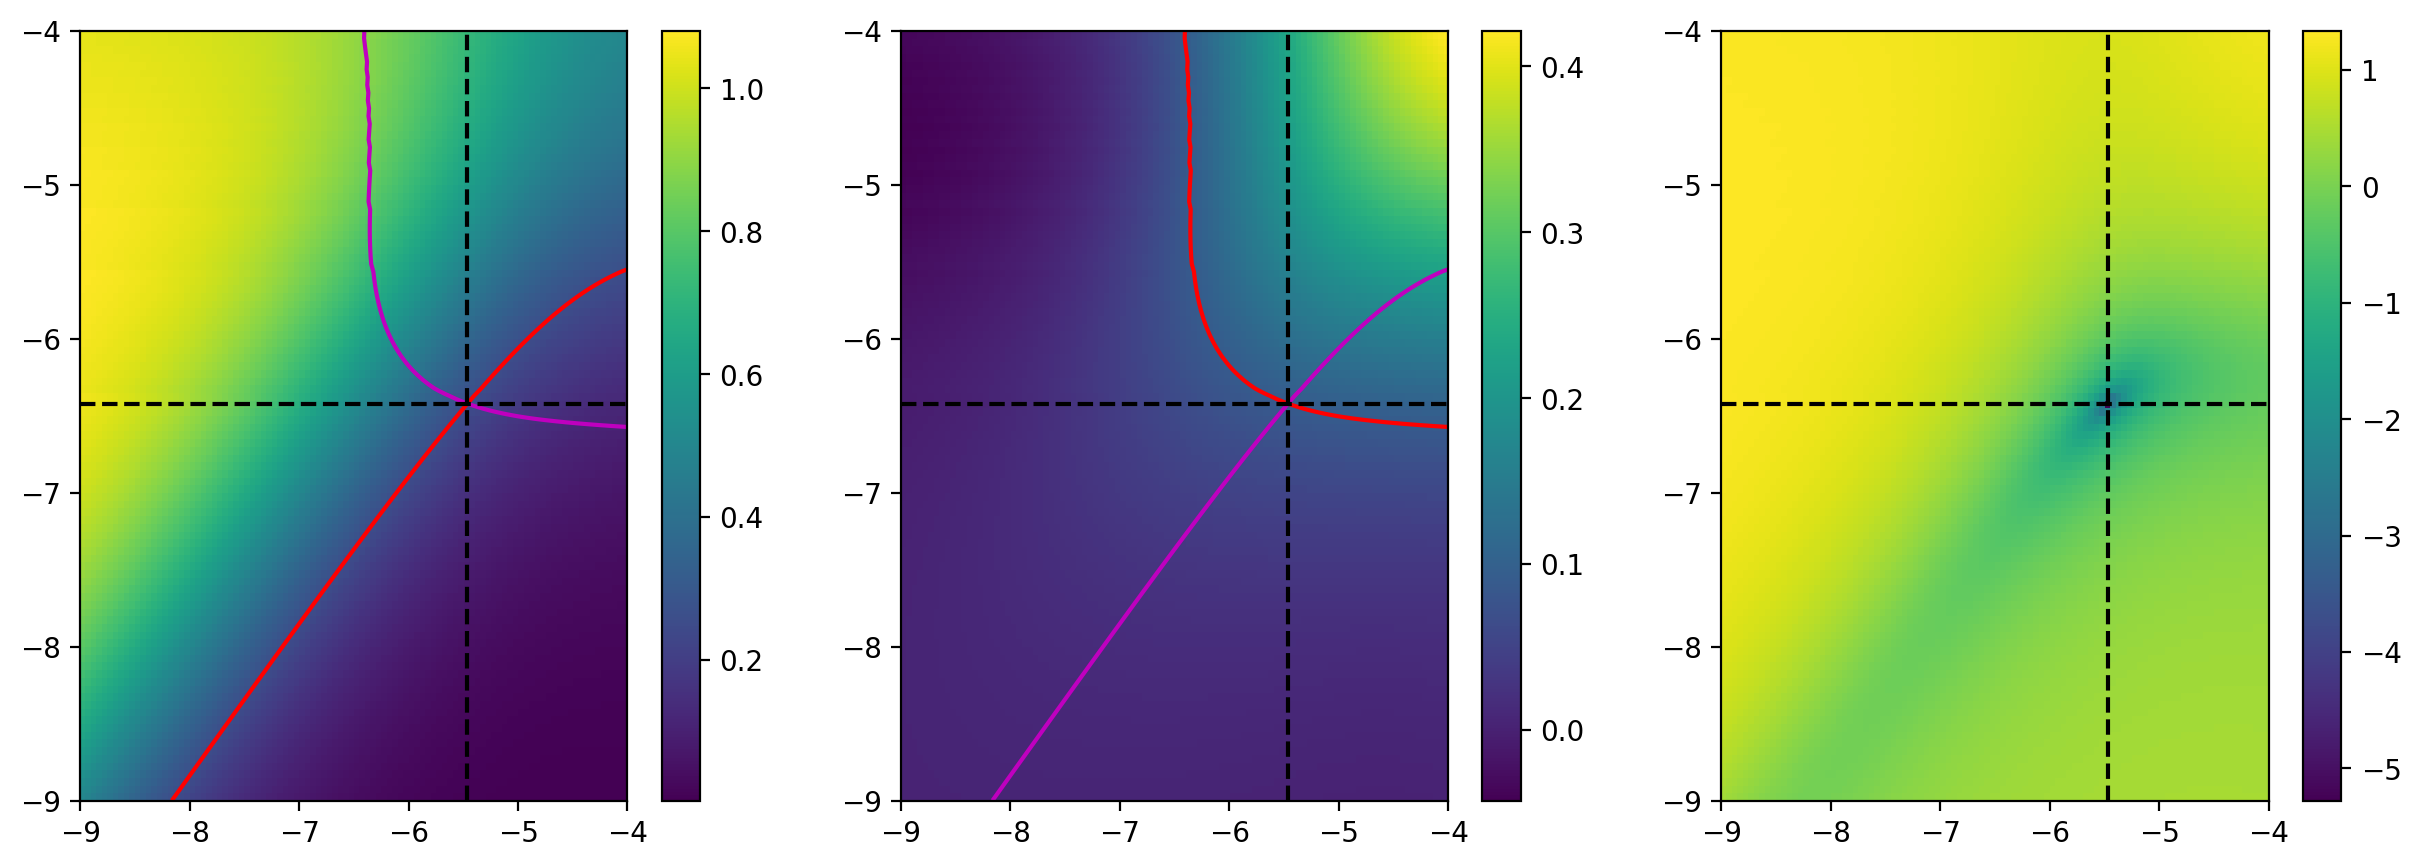

In [10]:
lPro = np.linspace(-9,-4,100)
lTrp = np.linspace(-9,-4,100)


xmat, ymat = np.meshgrid(lPro, lTrp)

eq_data = df.loc[df['Condition']=='A']['Ratio'].values 
growth_data = df.loc[df['Condition']=='A']['Width'].mean() / df.loc[df['Condition']=='WT']['Width'].mean() 


community_A = community(lPro=10**xmat, lTrp=10**ymat) 

x = lPro
y = lTrp
z1 = community_A.eq
z1_data = eq_data

z2 = community_A.rel_growth_wt
z2_data = np.atleast_1d(np.array(growth_data))

xfit, yfit = fit_2D(x, y, z1, z2, z1_data, z2_data)

lPro_fit = 10**xfit
lTrp_fit = 10**yfit

print(f"Pro leakage = {lPro_fit:.3g} (original = {wt_community.lPro:.3g}), Trp leakage = {lTrp_fit:.3g} (original = {wt_community.lTrp:.3g})")

---
## Characterize putP using community B

### fit increase in Pro uptake by putP over expression (assuming no cost)

First we fit increase in uptake base on change in growth range

fold change Pro uptake = 109.00, relative patch size dP/dT pred = 0.82, relative patch size pred data = 0.82
fold change Pro uptake = 78.00, relative patch size WT/putP pred = 0.19, relative patch size pred data = 0.19


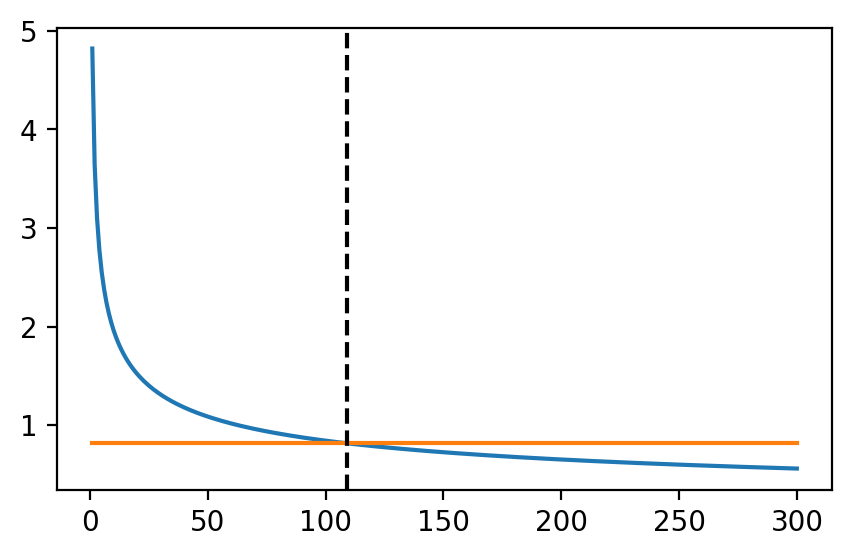

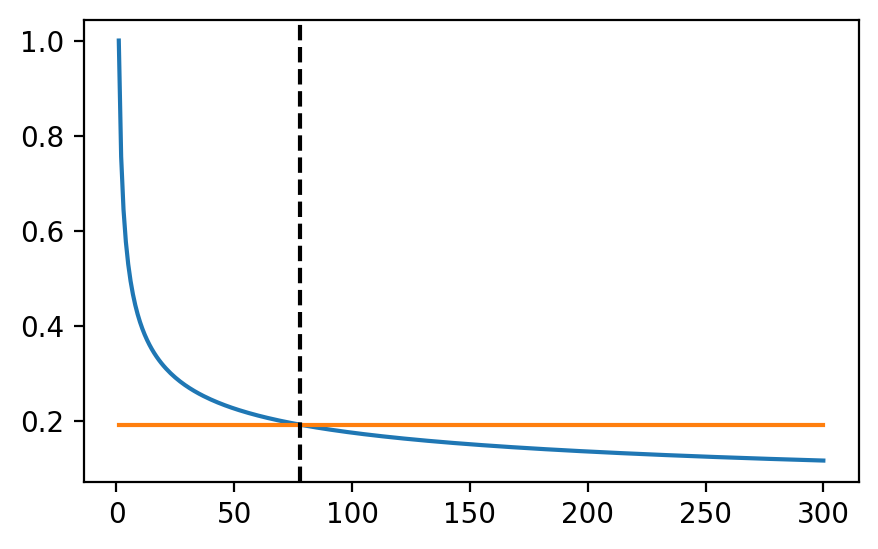

In [27]:
# get baseline community
community_A = community()

#get measured value
rel_dPdT_patch_data = df.loc[df['Condition']=='B']['rel_range'].values 
rel_dP_patch_data = df.loc[df['Condition']=='B']['dP_patch'].mean() / df.loc[df['Condition']=='A']['dP_patch'].mean()

#calc model predictions with varying cost for putP
c_up_P = np.linspace(1,300,300)
community_B_up = community(c_up_P=c_up_P, c_cost_dP=1)

#find cost that minimized L2 norm, based on rel patch size between dT and dP
c_up_P_fit, rel_patch_pred = fit_1D(c_up_P, rel_dPdT_patch_data, community_B_up.rangeP / community_B_up.rangeT)
#report fitted cost
print(f"fold change Pro uptake = {c_up_P_fit:.2f}, relative patch size dP/dT pred = {rel_patch_pred:.2f}, relative patch size pred data = {rel_dPdT_patch_data.mean():.2f}")

#find cost that minimized L2 norm, based on change in patch size of dP
c_up_P_fit2, rel_patch_pred2 = fit_1D(c_up_P, rel_dP_patch_data, community_B_up.rangeP / community_A.rangeP)
#report fitted cost
print(f"fold change Pro uptake = {c_up_P_fit2:.2f}, relative patch size WT/putP pred = {rel_patch_pred2:.2f}, relative patch size pred data = {rel_dP_patch_data.mean():.2f}")

### PutP over expression with costs from community B

we have two variables: cost and increase in uptake, and two measurement: change in ratio and change in sector size

#### Fit putP costs and increase in uptake by fitting eq ratio and relative sector size (dP/dT) for community B

fold change Pro uptake = 266.000, cost putP = 0.215


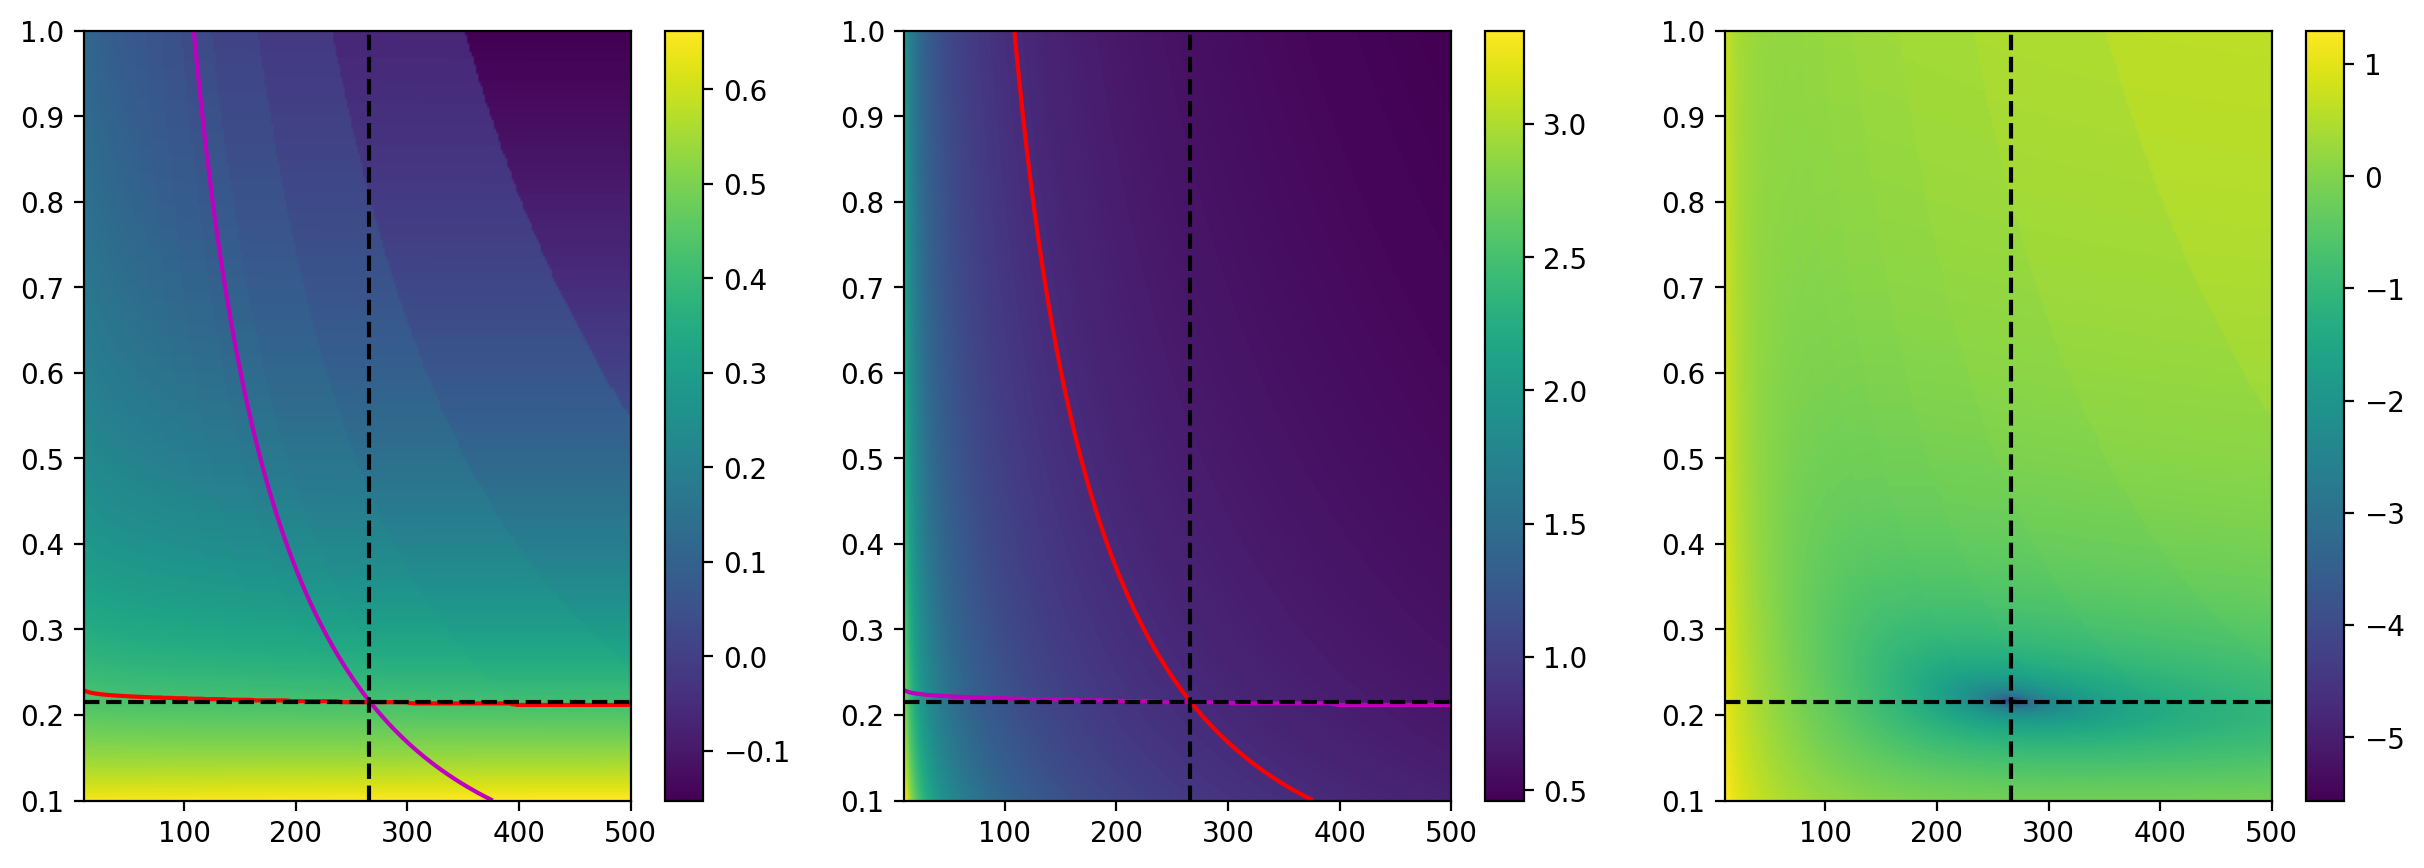

In [28]:
c_up_P = np.linspace(10,500,246)
cost_putP = np.linspace(0.1,1,181)
xmat = np.repeat(np.atleast_2d(c_up_P), len(cost_putP), axis = 0)
ymat = np.repeat(np.atleast_2d(cost_putP).T, len(c_up_P), axis = 1)

eq_data = df.loc[df['Condition']=='B']['Ratio'].values 
rel_dPdT_patch_data = df.loc[df['Condition']=='B']['rel_range'].values 

community_B = community(c_up_P=xmat, c_cost_dP=ymat) 

x = c_up_P
y = cost_putP
z1 = community_B.eq
z1_data = eq_data
# z1[z1<0] = 0
# z1[z1>1] = 1

z2 = community_B.rangeP / community_B.rangeT
z2_data = rel_dPdT_patch_data

xfit, yfit = fit_2D(x, y, z1, z2, z1_data, z2_data)

c_up_P_fit = xfit
cost_putP_fit = yfit

print(f"fold change Pro uptake = {c_up_P_fit:.3f}, cost putP = {cost_putP_fit:.3f}")


fold change Pro uptake = 360.000, cost putP = 0.435


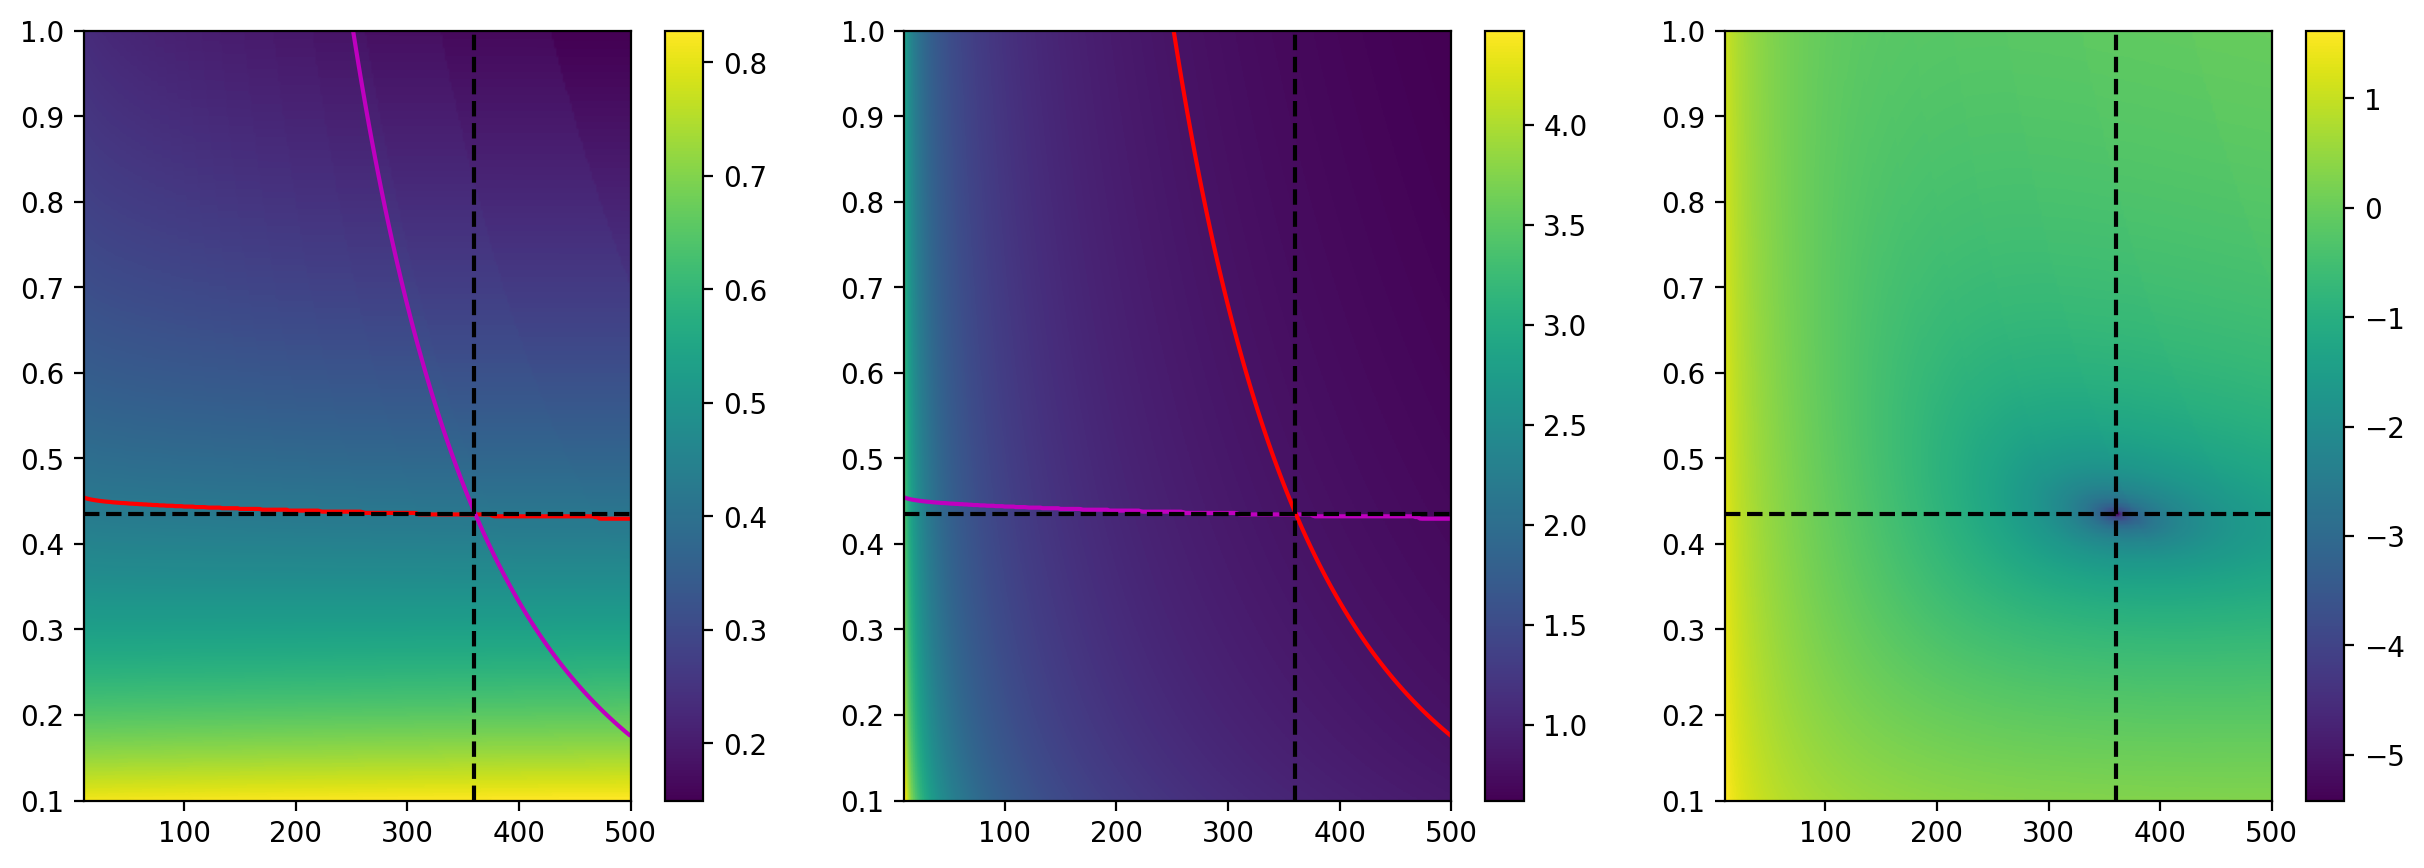

In [29]:
c_up_P = np.linspace(10,500,246)
cost_putP = np.linspace(0.1,1,181)
xmat = np.repeat(np.atleast_2d(c_up_P), len(cost_putP), axis = 0)
ymat = np.repeat(np.atleast_2d(cost_putP).T, len(c_up_P), axis = 1)

eq_data = df.loc[df['Condition']=='B']['Ratio'].values 
rel_dPdT_patch_data = df.loc[df['Condition']=='B']['rel_range'].values 

community_B_mod = community(c_up_P=xmat, c_cost_dP=ymat, lTrp=lTrp_fit, lPro=lPro_fit) 

x = c_up_P
y = cost_putP
z1 = community_B_mod.eq
z1_data = eq_data
# z1[z1<0] = 0
# z1[z1>1] = 1

z2 = community_B_mod.rangeP / community_B_mod.rangeT
z2_data = rel_dPdT_patch_data

xfit, yfit = fit_2D(x, y, z1, z2, z1_data, z2_data)

c_up_P_fit2 = xfit
cost_putP_fit2 = yfit

print(f"fold change Pro uptake = {c_up_P_fit2:.3f}, cost putP = {cost_putP_fit2:.3f}")


----

## Characterize trpR using community C



### Fit trpR cost and increase in trp release for community C based on EQ data - assuming no cost

fold change Trp leakage = 131.52, EQ pred = 0.59, EQ data = 0.59
fold change Trp leakage = 1000.00, EQ pred = 0.54, EQ data = 0.59


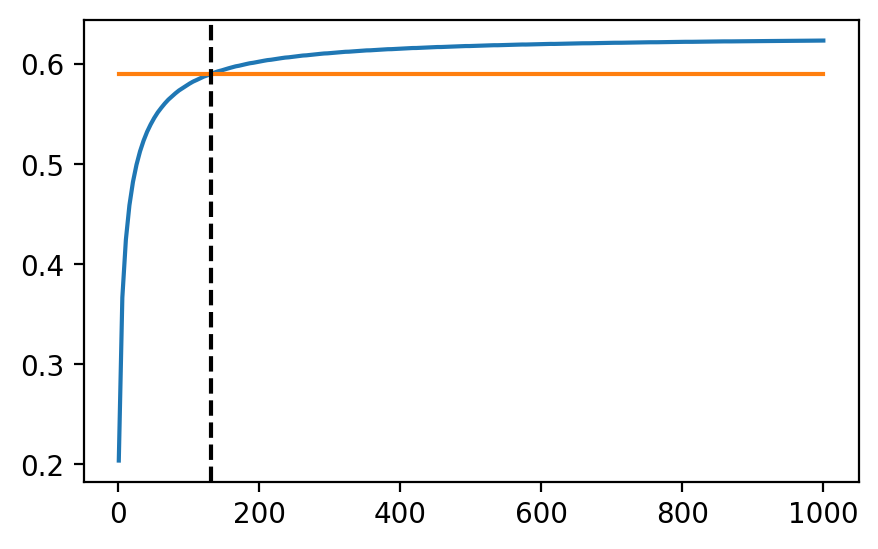

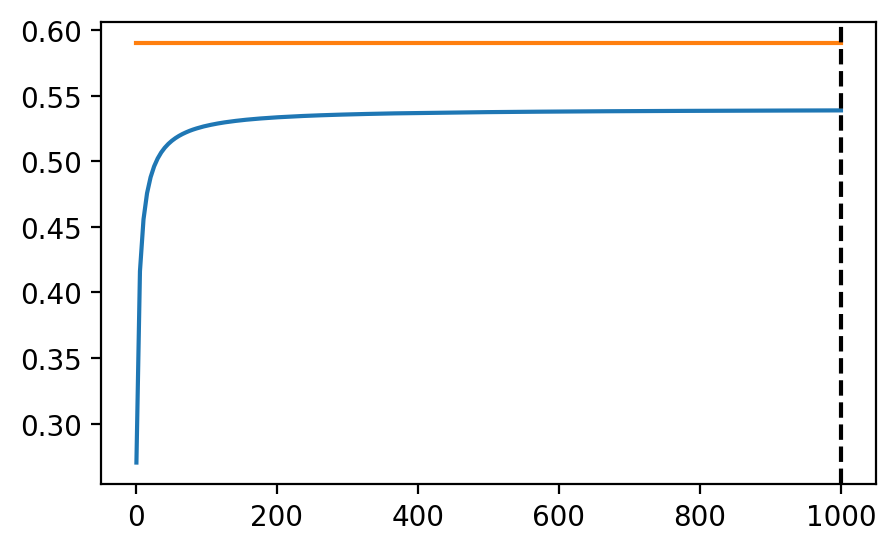

In [38]:
#get measured value
eq_data = df.loc[df['Condition']=='C']['Ratio'].values 

#calc model predictions with varying cost for putP
c_prod_T = np.linspace(1,1000,200)
community_C_prod = community(c_prod_T=c_prod_T, c_cost_dP=1)

#find cost that minimized L2 norm, based on rel patch size between dT and dP
c_prod_fit, eq_fit = fit_1D(c_prod_T, eq_data, community_C_prod.eq)
#report fitted cost
print(f"fold change Trp leakage = {c_prod_fit:.2f}, EQ pred = {eq_fit:.2f}, EQ data = {eq_data.mean():.2f}")


#calc model predictions with varying cost for putP
community_C_prod_mod = community(c_prod_T=c_prod_T, c_cost_dP=1, lTrp=lTrp_fit, lPro=lPro_fit)

#find cost that minimized L2 norm, based on rel patch size between dT and dP
c_prod_fit2, eq_fit = fit_1D(c_prod_T, eq_data, community_C_prod_mod.eq)
#report fitted cost
print(f"fold change Trp leakage = {c_prod_fit2:.2f}, EQ pred = {eq_fit:.2f}, EQ data = {eq_data.mean():.2f}")


### Try to fit cost

We cannot fit costs, as we do not have second read-out, there is thus a whole space of possible cost and leakage rates that fit the model

fold change Trp leakage = 14.870, cost trpR = 0.043


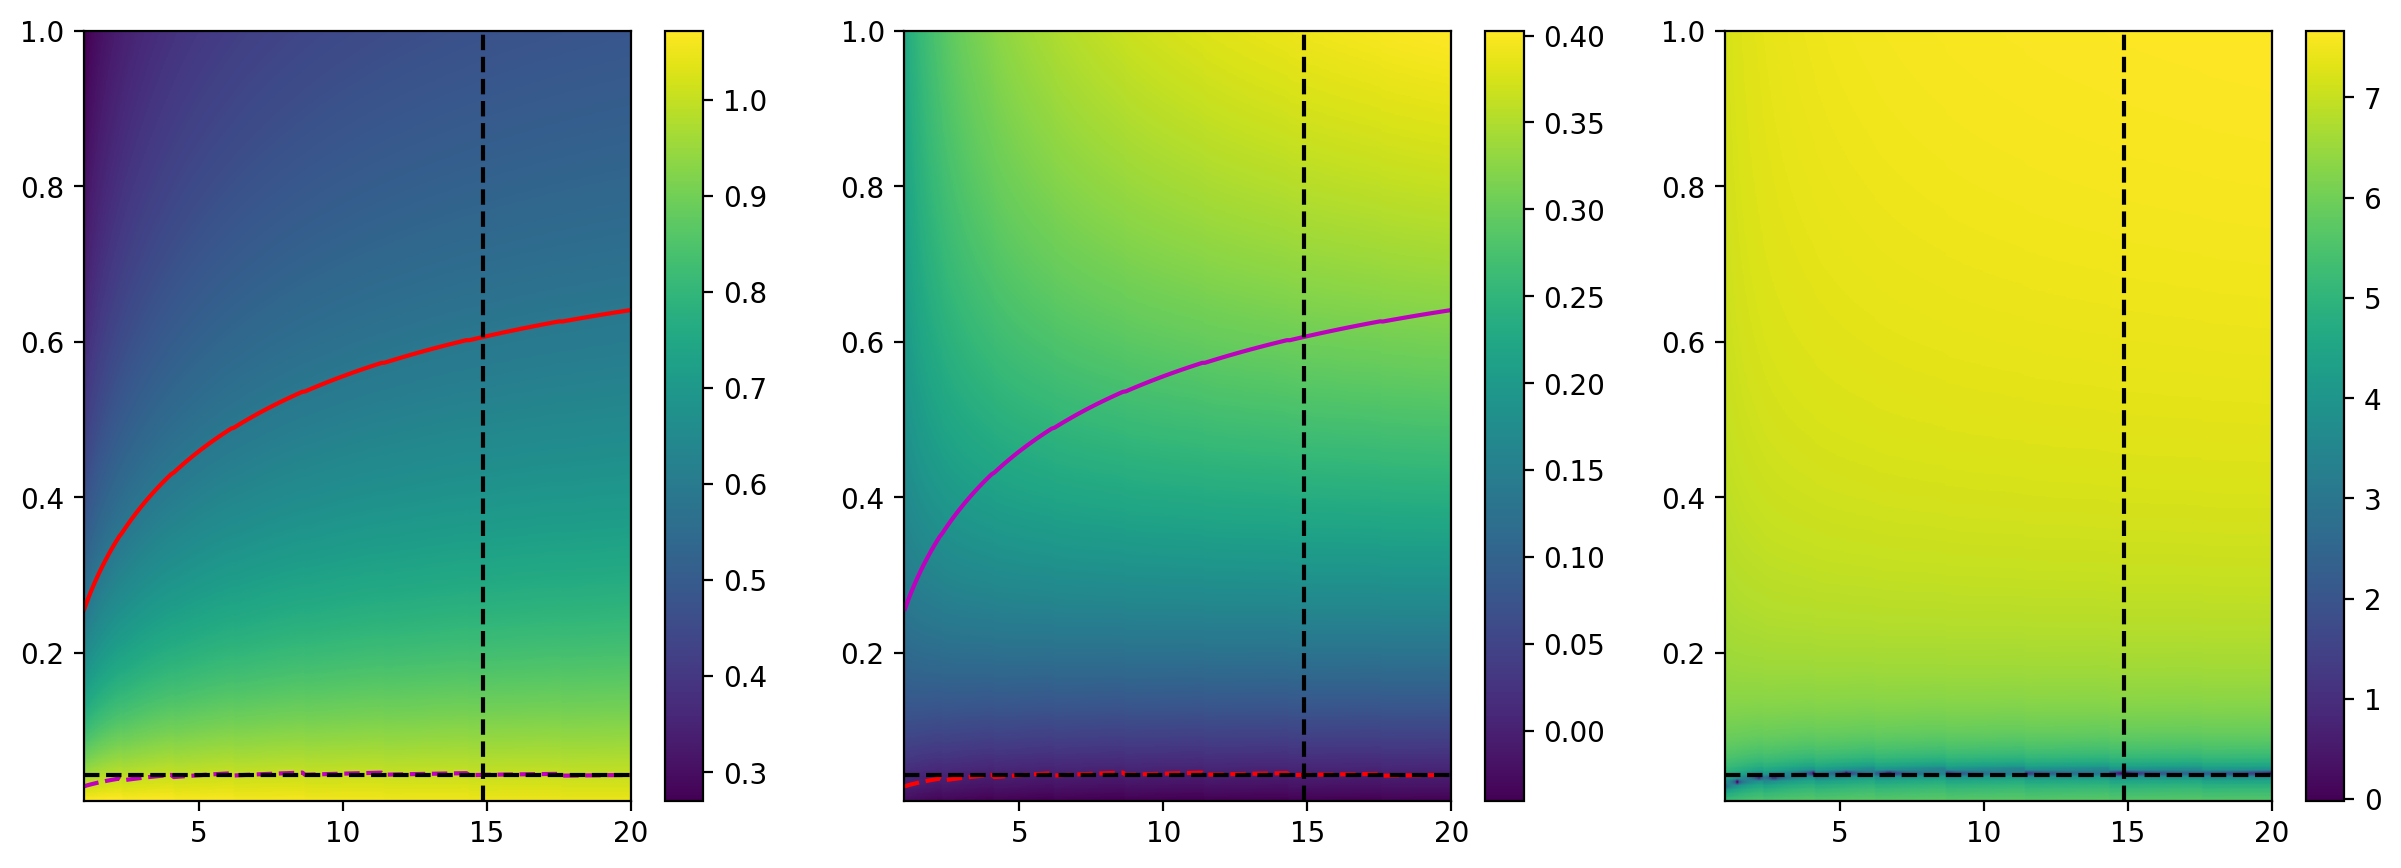

In [41]:
c_prod_T = np.linspace(1,20,201)
cost_trpR = np.linspace(0.01,1,181)

xmat = np.repeat(np.atleast_2d(c_prod_T), len(cost_trpR), axis = 0)
ymat = np.repeat(np.atleast_2d(cost_trpR).T, len(c_prod_T), axis = 1)

eq_data = df.loc[df['Condition']=='C']['Ratio'].values 
growth_data = df.loc[df['Condition']=='C']['Width'].mean() / df.loc[df['Condition']=='WT']['Width'].mean() 


community_C_mod = community(c_prod_T=xmat, c_cost_dP=ymat,lTrp=lTrp_fit, lPro=lPro_fit) 

x = c_prod_T
y = cost_trpR
z1 = community_C_mod.eq
z1_data = eq_data

z2 = community_C_mod.rel_growth_wt
z2_data = np.atleast_1d(np.array(growth_data))

xfit, yfit = fit_2D(x, y, z1, z2, z1_data, z2_data)

c_prod_T_fit = xfit
cost_trpR_fit = yfit

print(f"fold change Trp leakage = {c_prod_T_fit:.3f}, cost trpR = {cost_trpR_fit:.3f}")

----

## Characterize proB74 using community E



### Fit proB74 cost and increase in pro release for community E based on EQ data - assuming no cost

fold change Pro leakage = 1.38, EQ pred = 0.19, EQ data = 0.19
fold change Pro leakage = 20.00, EQ pred = 0.24, EQ data = 0.19


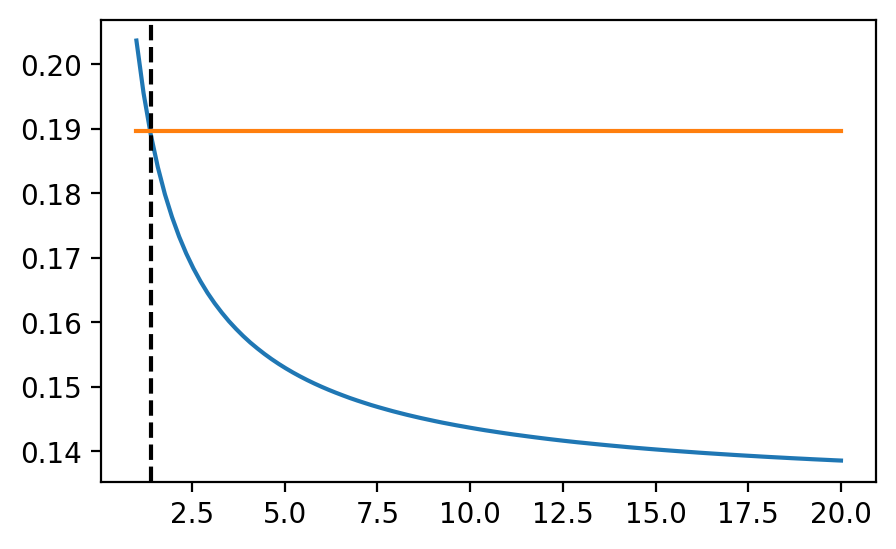

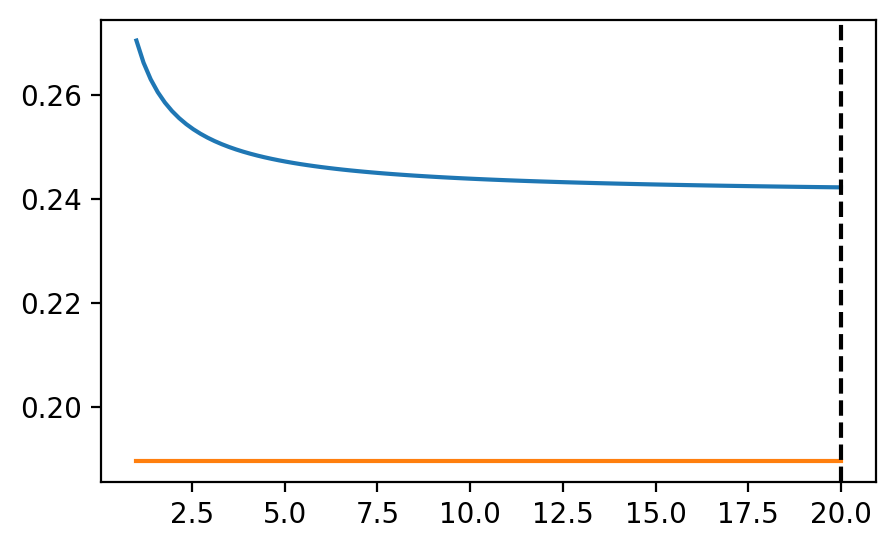

In [44]:
#get measured value
eq_data = df.loc[df['Condition']=='E']['Ratio'].values 

#calc model predictions with varying cost for putP
c_prod_P = np.linspace(1,20,100)
community_E_prod = community(c_prod_P=c_prod_P, c_cost_dT=1)

#find cost that minimized L2 norm, based on rel patch size between dT and dP
c_prod_P_fit, eq_fit = fit_1D(c_prod_P, eq_data, community_E_prod.eq)
#report fitted cost
print(f"fold change Pro leakage = {c_prod_P_fit:.2f}, EQ pred = {eq_fit:.2f}, EQ data = {eq_data.mean():.2f}")


community_E_prod_mod = community(c_prod_P=c_prod_P, c_cost_dT=1, lTrp=lTrp_fit, lPro=lPro_fit)

#find cost that minimized L2 norm, based on rel patch size between dT and dP
c_prod_P_fit2, eq_fit = fit_1D(c_prod_P, eq_data, community_E_prod_mod.eq)
#report fitted cost
print(f"fold change Pro leakage = {c_prod_P_fit2:.2f}, EQ pred = {eq_fit:.2f}, EQ data = {eq_data.mean():.2f}")

### Try to fit cost

We cannot fit costs, as we do not have second read-out, there is thus a whole space of possible cost and leakage rates that fit the model

fold change Trp leakage = 4.465, cost trpR = 0.765


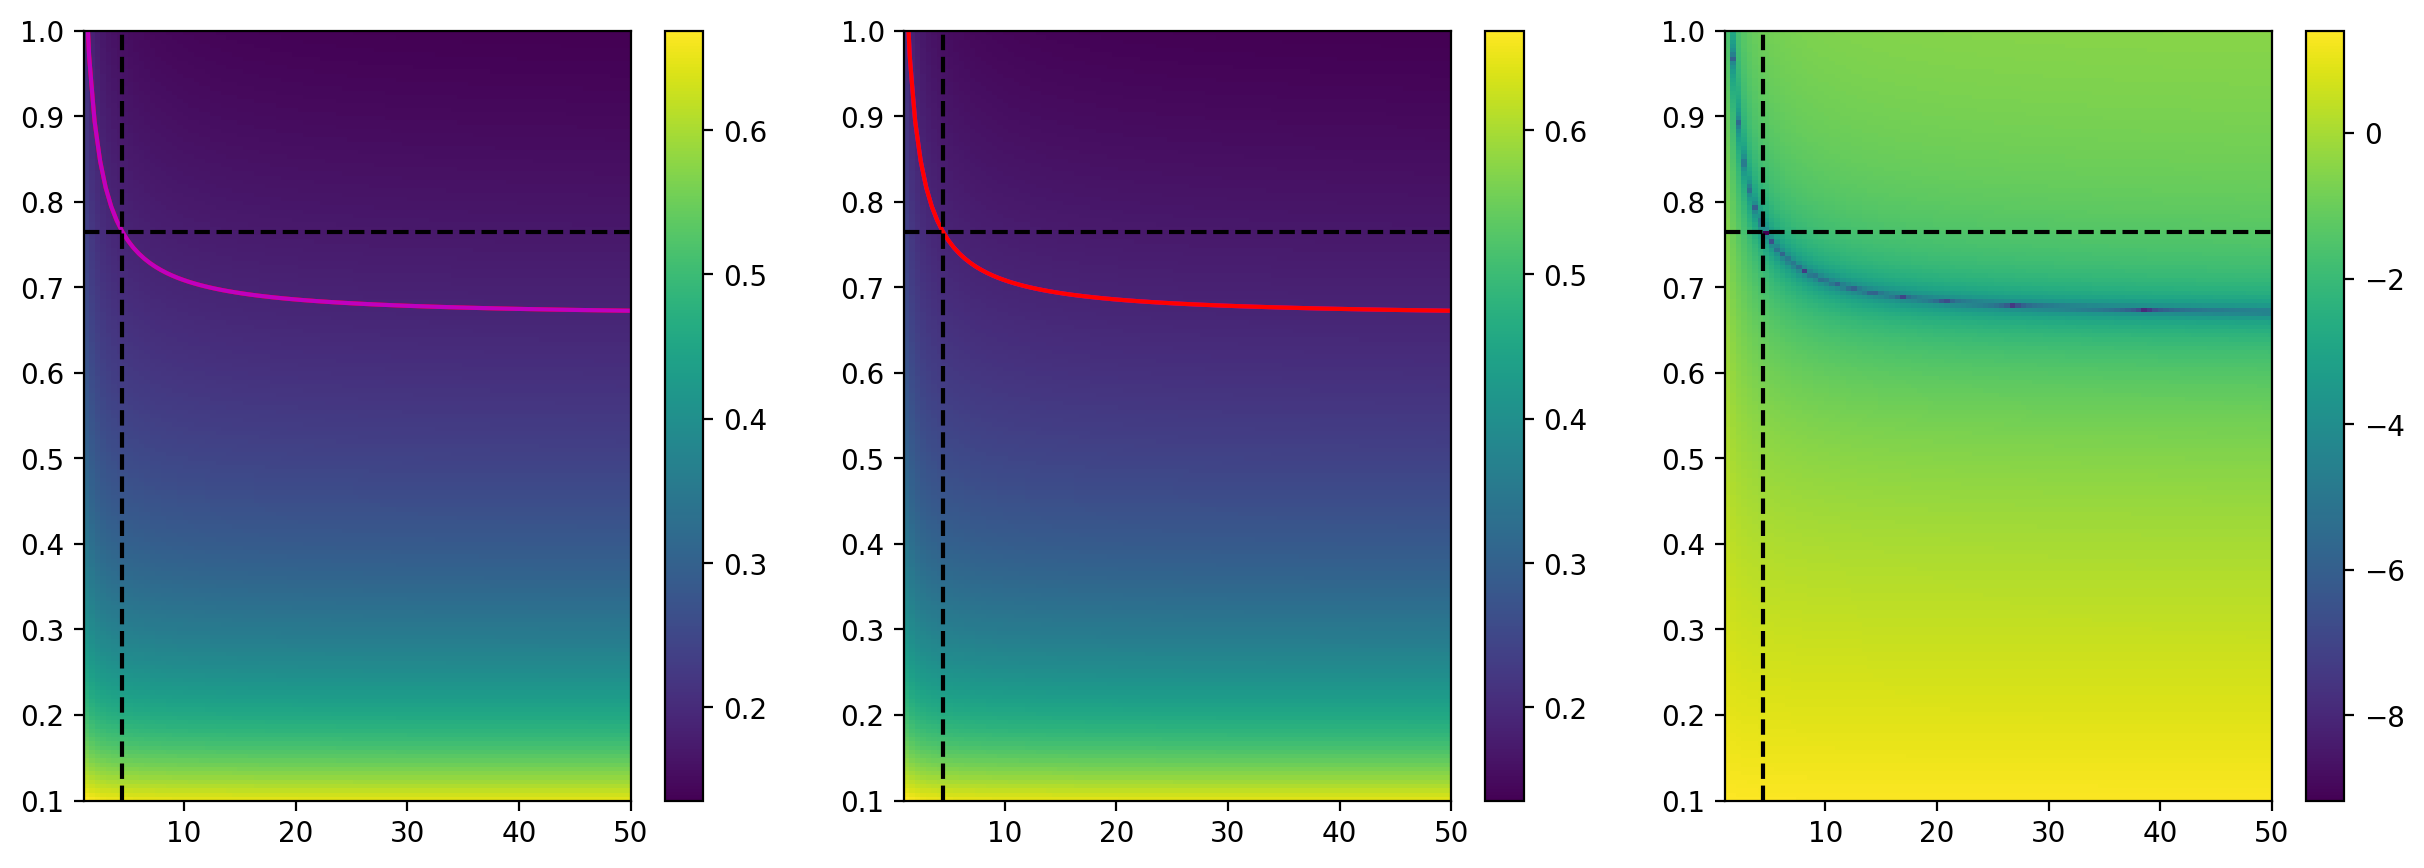

In [43]:
c_prod_P = np.linspace(1,50,100)
cost_proB74 = np.linspace(0.1,1,181)

xmat = np.repeat(np.atleast_2d(c_prod_P), len(cost_proB74), axis = 0)
ymat = np.repeat(np.atleast_2d(cost_proB74).T, len(c_prod_P), axis = 1)

eq_data = df.loc[df['Condition']=='E']['Ratio'].values 
rel_dPdT_patch_data = df.loc[df['Condition']=='E']['rel_range'].values 

community_E = community(c_prod_P=xmat, c_cost_dP=ymat) 

x = c_prod_P
y = cost_proB74
z1 = community_E.eq
z1_data = eq_data
# z1[z1<0] = 0
# z1[z1>1] = 1

z2 = z1
z2_data = z1_data

xfit, yfit = fit_2D(x, y, z1, z2, z1_data, z2_data)

c_prod_P_fit = xfit
cost_proB74_fit = yfit

print(f"fold change Trp leakage = {c_prod_P_fit:.3f}, cost trpR = {cost_proB74_fit:.3f}")